# Utilizando decoders para Multiple Choice Answering (MCA)

El propósito de este notebook es experimentar con diferentes decoders para tareas de Multiple Choice Answering (MCA) utilizando modelos preentrenados de Hugging Face. 
El procedimiento con el cual se trabajará es el siguiente:
1. Carga de un modelo y tokenizer preentrenado.
2. Preparación del prompt de entrada para el modelo con el fin de obtener una respuesta (entre A y E) correspondiente a la opción correcta.
3. Evaluación del desempeño del modelo en un conjunto de datos de prueba.

In [ ]:
# imports
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer # para embeddings
import torch
import pandas as pd

import numpy as np
from tqdm import tqdm

# base de datos vectorial
import chromadb


# métricas de clasificación
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

# visualización
import matplotlib.pyplot as plt
import seaborn as sns
from peft import PeftModel

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/estudiante/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# modelos a usar
MODEL_NAME1 = "mistralai/Mistral-7B-Instruct-v0.3"
MODEL_NAME2 = "medalpaca/MedAlpaca-7B"
MODEL_NAME3 = "microsoft/MediPhi-MedCode"

Se crea a continuación una función para cargar el modelo y el tokenizador.

In [ ]:
def load_model_and_tokenizer(model_name:str):
    """
    Cargar un modelo y su tokenizador en formato de precisión mixta (float16) y mover el modelo a GPU.
    Args:
        model_name (str): Nombre del modelo preentrenado en Hugging Face.
    Returns:
        model: El modelo cargado en formato float16 y movido a GPU.
        tokenizer: El tokenizador correspondiente al modelo.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype=torch.float16,
        device_map="auto"
    ).to("cuda")
    model.eval()
    return model, tokenizer

Para obtener la respuesta correcta de un dataset con multiples opciones, se define un prompt que incluya la pregunta y las opciones de respuesta disponibles junto con una letra indicadora (A, B, C, D, E). 
El modelo generará un único token como respuesta, y se toman los logits de esta última salida del modelo para determinar que letra tiene la mayor probabilidad de ser la respuesta correcta (haciendo uso de una función softmax en escala logarítimica).

In [ ]:
# Funcion para asignarle un score a cada respuesta
def score_response_logits(model:AutoModelForCausalLM, tokenizer:AutoTokenizer, question:str, answers:list[str]) -> str:
    """
    Dada una pregunta y una lista de respuestas posibles, devuelve la respuesta con mayor probabilidad según el modelo.
    Args:
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
        question (str): Pregunta a evaluar.
        answers (list[str]): Lista de respuestas posibles.
    Returns:
        str: Respuesta con mayor probabilidad según el modelo.
    """
    # eliminar la última respuesta si es "Respuesta incorrecta", para no generar esa opción
    if answers[4] == "Respuesta incorrecta":
        answers = answers[:-1]
    letters = ['A', 'B', 'C', 'D', 'E'][:len(answers)]

    options_text = "\n".join(f"{letters[i]}) {answers[i]}" for i in range(len(answers)))

    # crear prompt
    prompt = f"""
Eres un examinador experto en ambitos biomedicos.
Debes seleccionar la opción correcta entre las siguientes.
Responde únicamente con UNA letra (A, B, C, D o E) según corresponda.
Piensa paso a paso.

Pregunta:
{question}

Opciones:
{options_text}

Respuesta (solo la letra):
""".strip()

    # pasar prompt a tokens (ids)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]

    # generar un token (la letra) y mirar la probabilidad
    scores = []
    with torch.no_grad():
        outputs = model(input_ids, max_new_tokens=1)
        logits = outputs.logits  # [batch = 1, seq_len, vocab_size]
        last_token_logits = logits[0, -1, :] # tomar los logits del último token (letra generada)
        for letter in letters:
            token_id = tokenizer.convert_tokens_to_ids(letter)
            log_prob = torch.log_softmax(last_token_logits, dim=-1)[token_id].item() # tomar la prob de generar cada letra
            scores.append(log_prob)

    best_index = scores.index(max(scores))
    best_answer = answers[best_index]
    return best_answer

Se cargan los datos para evaluar el desempeño de los modelos.

In [15]:
# cargar datos de test
test_data = pd.read_csv("data/test.csv", index_col=0)
test_data.head()

,qid,qtext,ra,image,answer_1,answer_2,answer_3,answer_4,answer_5
4039,87,El virión de los retrovirus:,4,NaN,Tiene forma helicoidal.,Tiene forma icosaédrica.,Contiene una sola copia de su genoma.,Contiene dos copias de su genoma.,Contiene un genoma segmentado.
4173,224,El suelo de la cavidad amniótica es el:,3,NaN,Trofoblasto.,Hipoblasto.,Epiblasto.,Endometrio.,Miometrio.
3975,18,Las señales sensitivas llegan principalmente a...,3,NaN,II.,III.,IV.,V.,VI.
2470,25,Las desviaciones instrumentales de la Ley de B...,2,NaN,Variaciones en la temperatura lo que provoca d...,Empleo de radiación no monocromática y presenc...,"Empleo de concentraciones elevadas de analito,...",La participación de la especie absorbente en u...,Respuesta incorrecta
2255,36,La presencia de síntomas o déficits que afecta...,3,NaN,Trastorno somatomorfo indiferenciado.,Trastorno de somatización.,Trastorno de conversión.,Trastorno por dolor.,Respuesta incorrecta


In [7]:
# inicializar modelo y tokenizer
model, tokenizer = load_model_and_tokenizer(MODEL_NAME1)

Loading checkpoint shards: 100%|█████████████████| 3/3 [00:08<00:00,  2.83s/it]


Se realiza una prueba de concepto con un ejemplo del dataset.

In [9]:
# ejemplo
example = test_data.iloc[12]
question = example["qtext"]
answers = [
    example["answer_1"],
    example["answer_2"],
    example["answer_3"],
    example["answer_4"],
    example["answer_5"],
]
real_answer = answers[example["ra"] - 1]
print("Pregunta:", question)
print("Respuestas:", answers)
print("Respuesta real:", real_answer)

Pregunta: Placa motora es la unión entre la neurona motora y el:
Respuestas: ['Músculo liso.', 'Músculo esquelético.', 'Músculo cardiaco.', 'Huso muscular.', 'Tendón.']
Respuesta real: Músculo esquelético.


In [110]:
# obtener la mejor respuesta segun el modelo
predicted_answer = score_response_logits(model, tokenizer, question, answers)
print("Respuesta predicha:", predicted_answer)
print("Respuesta correcta:", real_answer)

Respuesta predicha: Músculo esquelético.
Respuesta correcta: Músculo esquelético.


Se crea una función para evaluar el desempeño de los modelos en todo el dataset de testeo.

In [ ]:
def evaluate_model_logits(test_data: pd.DataFrame, model: AutoModelForCausalLM, tokenizer: AutoTokenizer):
    """
    Evaluar el desempeño del modelo en un conjunto de datos de prueba. Se muestran métricas como accuracy, F1-score, precision, recall y matriz de confusión.
    Args:
        test_data (pd.DataFrame): DataFrame con las preguntas, respuestas y respuestas correctas.
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
    Returns:
        dict: Diccionario con las métricas de evaluación."""
    all_preds = []
    all_labels = []

    total = len(test_data)

    for index, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating"):
        question = row["qtext"]
        answers = [
            row["answer_1"],
            row["answer_2"],
            row["answer_3"],
            row["answer_4"],
            row["answer_5"],
        ]
        real_answer = row["ra"]  # 1–5

        # obtener texto predicho
        predicted_answer = score_response_logits(model, tokenizer, question, answers)

        # convertir predicción a índice
        try:
            pred_index = answers.index(predicted_answer)  # 0–4
        except ValueError:
            # Si el modelo produce texto raro o fuera de las opciones
            pred_index = -1  # Clase inválida

        all_preds.append(pred_index)
        all_labels.append(real_answer - 1)  # convertir 1–5 a 0–4

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metricas
    valid_mask = all_preds != -1
    invalid_predictions = np.sum(all_preds == -1)

    print(f"Predicciones inválidas (fuera de opciones): {invalid_predictions}")

    if invalid_predictions > 0:
        print("Nota: las predicciones inválidas se excluyen de métricas de F1/precision/recall.")

    metrics = {
        "Accuracy": np.mean(all_preds == all_labels),
        "F1 Macro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "F1 Micro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "F1 Weighted": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Precision Macro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Precision Micro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Precision Weighted": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Recall Macro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Recall Micro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Recall Weighted": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),
    }

    print("Resultados de la evaluación:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels[valid_mask], all_preds[valid_mask]))

    cm = confusion_matrix(all_labels[valid_mask], all_preds[valid_mask])
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    labels = [1, 2, 3, 4, 5]  # clases 1–5

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return metrics


Evaluating: 100%|████████████████████████████| 790/790 [00:43<00:00, 18.27it/s]


Predicciones inválidas (fuera de opciones): 0
Resultados de la evaluación:
Accuracy: 0.5392
F1 Macro: 0.5370
F1 Micro: 0.5392
F1 Weighted: 0.5375
Precision Macro: 0.5533
Precision Micro: 0.5392
Precision Weighted: 0.5441
Recall Macro: 0.5302
Recall Micro: 0.5392
Recall Weighted: 0.5392
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       191
           1       0.57      0.45      0.50       190
           2       0.51      0.56      0.53       171
           3       0.56      0.53      0.54       181
           4       0.61      0.47      0.53        57

    accuracy                           0.54       790
   macro avg       0.55      0.53      0.54       790
weighted avg       0.54      0.54      0.54       790



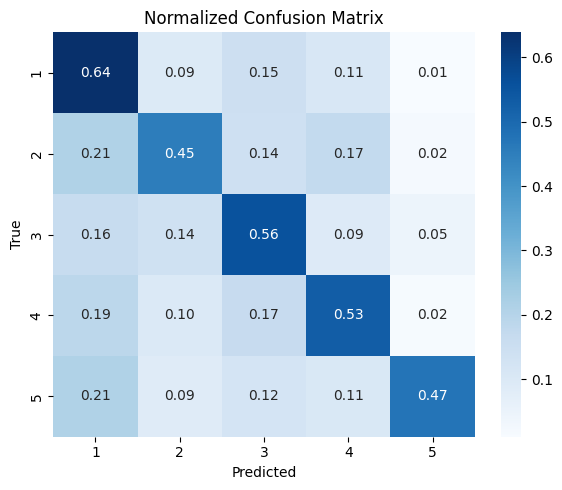

In [84]:
metrics = evaluate_model_logits(test_data, model, tokenizer)

---

# Prueba con decoder finetuneado con LoRA en ámbito biomédico

La siguiente prueba se realiza con un modelo finetuneado en base a BioMistral-7B utilizando LoRA en un conjunto de datos biomédico en español.

In [ ]:
# Cargar el modelo base
base_model_name = "BioMistral/BioMistral-7B"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Cargar el modelo LoRA finetuneado sobre BioMistral-7B
lora_model_name = "somosnlp/spanish_medica_llm"

model = PeftModel.from_pretrained(
    base_model,
    lora_model_name,
    torch_dtype=torch.float16,
)


In [58]:
model = model.merge_and_unload()
model.to(device)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4096,)

In [ ]:
# Se carga el tokenizador correspondiente al modelo base
tokenizer = AutoTokenizer.from_pretrained(
    base_model_name,
    padding_side="left",
    truncation=True
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


Ejecutamos la misma función de scoring definida anteriormente sobre el modelo finetuneado.

In [ ]:
predicted_answer = score_response_logits(model, tokenizer, question, answers)
print("Respuesta predicha:", predicted_answer)
print("Respuesta correcta:", real_answer)

Respuesta predicha: Segmentos compactos de las proteínas globulares, que son estructuralmente independientes y poseen funciones específicas.
Respuesta correcta: Segmentos compactos de las proteínas globulares, que son estructuralmente independientes y poseen funciones específicas.


Se evalú el desempeño del modelo finetuneado.

Evaluating: 100%|████████████████████████████| 790/790 [03:28<00:00,  3.79it/s]


Predicciones inválidas (fuera de opciones): 0
Resultados de la evaluación:
Accuracy: 0.4304
F1 Macro: 0.4121
F1 Micro: 0.4304
F1 Weighted: 0.4361
Precision Macro: 0.4255
Precision Micro: 0.4304
Precision Weighted: 0.4604
Recall Macro: 0.4249
Recall Micro: 0.4304
Recall Weighted: 0.4304
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       191
           1       0.47      0.46      0.46       190
           2       0.56      0.33      0.42       171
           3       0.41      0.46      0.43       181
           4       0.20      0.40      0.27        57

    accuracy                           0.43       790
   macro avg       0.43      0.42      0.41       790
weighted avg       0.46      0.43      0.44       790



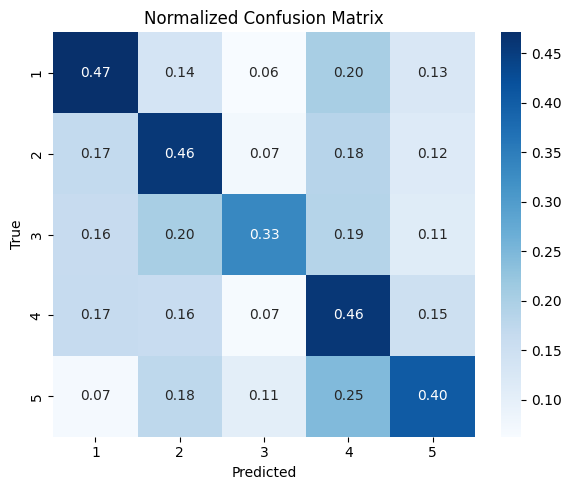

In [61]:
metrics = evaluate_model_logits(test_data, model, tokenizer)

Notamos que a pesar de ser un modelo específicamente diseñado para el ámbito biomédico en español, el desempeño no mejora significativamente en comparación con un modelo instruct como Mistral-Instruct-7B. Esto podría deberse a varios factores, incluyendo la calidad y cantidad del dataset de entrenamiento utilizado para el fine-tuning, así como la capacidad del modelo base para adaptarse a tareas específicas de MCA. Es posible que se requiera un ajuste más fino o un dataset más grande y diverso para lograr mejoras sustanciales en el rendimiento.

---
# Probando decoders con dataset traducido
Con el fin de evaluar comparar el desempeño de modelos finetuneados en el ámbito biomédico, se hace el ejercicio de traducir el dataset de test a inglés y se hace uso del modelo MedPhi-MedCode.
El proceso de traducción del dataset se puede encontrar en el notebook `traduccion_pregunta_respuestas.ipynb`.

In [ ]:
# cargar el modelo y tokenizador de MedPhi-MedCode
model3, tokenizer3 = load_model_and_tokenizer(MODEL_NAME3)

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:03<00:00,  1.80s/it]


Leer el dataframe de test en ingles.

In [6]:
test_df_en = pd.read_csv('data/test_en.csv', index_col=0)
test_df_en.head()

,qid,qtext_en,ra,answer_1_en,answer_2_en,answer_3_en,answer_4_en,answer_5_en
4039,87,The virion of retroviruses:,4,It has a helical shape.,It has an icosahedral shape.,It contains a single copy of its genome.,It contains two copies of its genome.,It contains a segmented genome.
4173,224,The floor of the amniotic cavity is:,3,Trophoblast.,Hypoblast.,Epiblast.,Endometrium.,Myometrium.
3975,18,Sensory signals primarily reach layer number o...,3,II.,III.,IV.,V.,VI.
2470,25,Instrumental deviations from Beer’s Law are ma...,2,Variations in temperature causing shifts in ch...,Use of non-monochromatic radiation and presenc...,"Use of high concentrations of analyte, which m...",The participation of the absorbing species in ...,Incorrect answer.
2255,36,The presence of symptoms or deficits affecting...,3,Undifferentiated somatoform disorder.,Somatization disorder.,Conversion disorder.,Pain disorder.,Incorrect answer.


Hacemos unas correcciones al clasificador teniendo en cuenta las nuevas columnas de preguntas y respuestas y el prompt en ingles. El procedimiento general no cambia.

In [ ]:
# Funcion para asignarle un score a cada respuesta
def score_response_logits_en(model:AutoModelForCausalLM, tokenizer:AutoTokenizer, question:str, answers:list[str]) -> str:
    """
    Dada una pregunta y una lista de respuestas posibles, devuelve la respuesta con mayor probabilidad según el modelo.
    Args:
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
        question (str): Pregunta a evaluar.
        answers (list[str]): Lista de respuestas posibles.
    Returns:
        str: Respuesta con mayor probabilidad según el modelo.
    """

    if answers[4] == "Incorrect Answer":
        answers = answers[:-1]
    letters = ['A', 'B', 'C', 'D', 'E'][:len(answers)]

    options_text = "\n".join(f"{letters[i]}) {answers[i]}" for i in range(len(answers)))

    prompt = f"""
You are an expert examiner in biomedical fields.
You must select the correct option from the following.
Respond with only ONE letter (A, B, C, D, or E) as appropriate.
Think step by step.

Question:
{question}

Options:
{options_text}

Answer (letter only):
""".strip()

    # pasar prompt a tokens (ids)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]

    # generar un token (la letra) y mirar la probabilidad
    scores = []
    with torch.no_grad():
        outputs = model(input_ids, max_new_tokens=1)
        logits = outputs.logits  # [batch = 1, seq_len, vocab_size]
        last_token_logits = logits[0, -1, :] # tomar los logits del último token (letra generada)
        for letter in letters:
            token_id = tokenizer.convert_tokens_to_ids(letter)
            log_prob = torch.log_softmax(last_token_logits, dim=-1)[token_id].item() # tomar la prob de generar cada letra
            scores.append(log_prob)

    best_index = scores.index(max(scores))
    best_answer = answers[best_index]
    return best_answer

De igual manera, se redefine la función de evaluación teniendo en cuenta los nombres de las nuevas columnas en inglés.

In [ ]:
def evaluate_model_logits_en(test_data:pd.DataFrame, model:AutoModelForCausalLM, tokenizer:AutoTokenizer):
    """
    Evalua el desempeño del modelo en un conjunto de datos de prueba. Se muestran métricas como accuracy, F1-score, precision, recall y matriz de confusión.
    Args:
        test_data (pd.DataFrame): DataFrame con las preguntas, respuestas y respuestas correctas.
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
    Returns:
        dict: Diccionario con las métricas de evaluación.
    """
    all_preds = []
    all_labels = []

    total = len(test_data)

    for index, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating"):
        question = row["qtext_en"]
        answers = [
            row["answer_1_en"],
            row["answer_2_en"],
            row["answer_3_en"],
            row["answer_4_en"],
            row["answer_5_en"],
        ]
        real_answer = row["ra"]  # 1–5

        # bbtener texto predicho
        predicted_answer = score_response_logits_en(model, tokenizer, question, answers)

        # convertir predicción a índice
        try:
            pred_index = answers.index(predicted_answer)  # 0–4
        except ValueError:
            # Si el modelo produce texto raro o fuera de las opciones
            pred_index = -1  # Clase inválida

        all_preds.append(pred_index)
        all_labels.append(real_answer - 1)  # convertir 1–5 a 0–4

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metricas
    valid_mask = all_preds != -1
    invalid_predictions = np.sum(all_preds == -1)

    print(f"Predicciones inválidas (fuera de opciones): {invalid_predictions}")

    if invalid_predictions > 0:
        print("Nota: las predicciones inválidas se excluyen de métricas de F1/precision/recall.")

    metrics = {
        "Accuracy": np.mean(all_preds == all_labels),
        "F1 Macro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "F1 Micro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "F1 Weighted": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Precision Macro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Precision Micro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Precision Weighted": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Recall Macro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Recall Micro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Recall Weighted": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),
    }

    print("Resultados de la evaluación:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels[valid_mask], all_preds[valid_mask]))

    cm = confusion_matrix(all_labels[valid_mask], all_preds[valid_mask])
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    labels = [1, 2, 3, 4, 5]  # clases 1–5

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return metrics


Hacemos una pequeña prueba.

In [17]:
# ejemplo
example = test_df_en.iloc[5]
question = example["qtext_en"]
answers = [
    example["answer_1_en"],
    example["answer_2_en"],
    example["answer_3_en"],
    example["answer_4_en"],
    example["answer_5_en"],
]
real_answer = answers[example["ra"] - 1]
print("Pregunta:", question)
print("Respuestas:", answers)
print("Respuesta real:", real_answer)

Pregunta: The term DOMAIN refers to:
Respuestas: ['The ends of the polypeptide chains of a protein.', 'Compact segments of globular proteins, which are structurally independent and have specific functions.', 'Combinations of alpha helices and beta sheets without a particular function.', 'Each of the individual polypeptide chains of an oligomer.', 'The structure of fibrous proteins.']
Respuesta real: Compact segments of globular proteins, which are structurally independent and have specific functions.


In [18]:
# obtener la mejor respuesta segun el modelo
predicted_answer = score_response_logits_en(model3, tokenizer3, question, answers)
print("Respuesta predicha:", predicted_answer)
print("Respuesta correcta:", real_answer)

Respuesta predicha: Compact segments of globular proteins, which are structurally independent and have specific functions.
Respuesta correcta: Compact segments of globular proteins, which are structurally independent and have specific functions.


Evaluamos las métricas.

Evaluating: 100%|█████████████████████████████| 790/790 [00:27<00:00, 29.12it/s]


Predicciones inválidas (fuera de opciones): 0
Resultados de la evaluación:
Accuracy: 0.6519
F1 Macro: 0.6478
F1 Micro: 0.6519
F1 Weighted: 0.6520
Precision Macro: 0.6551
Precision Micro: 0.6519
Precision Weighted: 0.6660
Recall Macro: 0.6524
Recall Micro: 0.6519
Recall Weighted: 0.6519
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.58      0.67       191
           1       0.60      0.72      0.66       190
           2       0.63      0.72      0.67       171
           3       0.64      0.60      0.62       181
           4       0.60      0.65      0.62        57

    accuracy                           0.65       790
   macro avg       0.66      0.65      0.65       790
weighted avg       0.67      0.65      0.65       790



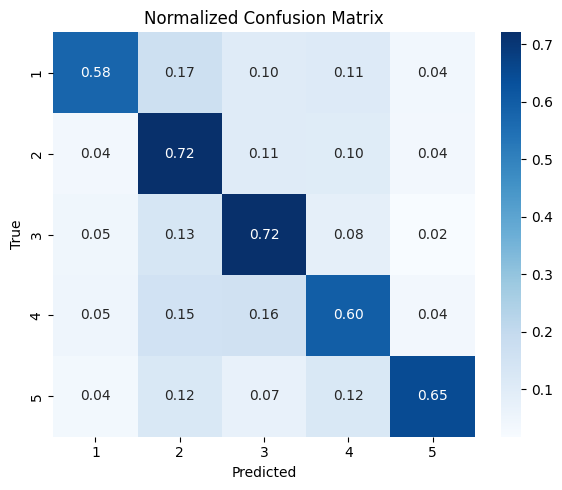

In [19]:
metrics = evaluate_model_logits_en(test_df_en, model3, tokenizer3)

Podemos observar que el desempeño en el modelo finetuneado en inglés es mucho mejor que el desempeño del modelo finetuneado en español, lo cual sugiere que el modelo base y el dataset de fine-tuning en inglés son más adecuados para la tarea de MCA en este contexto.